Finding effective transformation for data augmentation

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import math
import torch
import seaborn as sns

from utils import get_unet_model
from adv_bias import AdvBias
from adv_morph import AdvMorph
from adv_noise import AdvNoise
from adv_affine import AdvAffine

from utils import _disable_tracking_bn_stats,set_grad
from adv_compose_solver import ComposeAdversarialTransformSolver
from vis import plot_warped_grid, plot_noise,plot_bias_field,plot_image,plot_general
%matplotlib inline
sns.set()

In [70]:
torch.cuda.empty_cache()


1. 1 Load data

In [71]:
def load_image_label(image_path,label_path,slice_id=0, crop_size=(192,192)):

    image = sitk.GetArrayFromImage(sitk.ReadImage(image_path))[slice_id]
    label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))[slice_id]

    print ('image size:',image.shape)
    print ('label size:',label.shape)
    h_diff = (image.shape[0]-crop_size[0])//2
    w_diff = (image.shape[1]-crop_size[1])//2

    cropped_image = image[h_diff:crop_size[0]+h_diff,w_diff:crop_size[1]+w_diff]
    cropped_label = label[h_diff:crop_size[0]+h_diff,w_diff:crop_size[1]+w_diff]

    # rescale image intensities to 0-1
    cropped_image = (cropped_image-cropped_image.min())/(cropped_image.max()-cropped_image.min()+1e-10)
    return cropped_image,cropped_label


## prostate dataset:
crop_size = (224,224)
slice_id=5
image_path = '/vol/biomedic3/cc215/data/MedicalDecathlon/Task05_Prostate/preprocessed/patient_00/t2_img.nrrd'
label_path = '/vol/biomedic3/cc215/data/MedicalDecathlon/Task05_Prostate/preprocessed/patient_00/label.nrrd'
cropped_image,cropped_label =load_image_label (image_path,label_path,slice_id=slice_id,crop_size=crop_size)




image size: (307, 307)
label size: (307, 307)


1.2 Preprocessing data

(-0.5, 223.5, 223.5, -0.5)

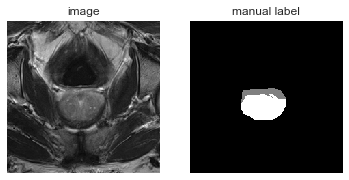

In [72]:
font_size=12
plt.subplot(121)
plt.title('image',size=font_size)
plt.imshow(cropped_image,cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(cropped_label,cmap='gray')
plt.title('manual label',size=font_size)
plt.axis('off')


2.1 Load a segmentation model

In [73]:
use_gpu=True
model = get_unet_model(num_classes=3,model_path='/vol/biomedic3/cc215/Project/DeformADA/result/Prostate_Segmentation/varying_subjects/supervised/full/affine_elastic_intensity_opt/0_cval_1/best/checkpoints/UNet_16$SAX$_Segmentation.pth',model_arch='UNet_16')

if use_gpu: model = model.cuda()
model.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

image size: (307, 307)
label size: (307, 307)


(-0.5, 223.5, 223.5, -0.5)

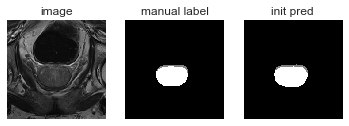

In [74]:
cropped_image,cropped_label =load_image_label (image_path,label_path,slice_id=8,crop_size=crop_size)
font_size=12
image_tensor = torch.from_numpy(cropped_image[np.newaxis,np.newaxis,:,:]).float()
if use_gpu: image_tensor = image_tensor.cuda()
image_tensor.requires_grad=False
model.eval()
with torch.no_grad():
    init_output = model(image_tensor)
pred_map = init_output.max(1)[1].cpu().data.numpy()

plt.subplot(131)
plt.title('image',size=font_size)
plt.imshow(cropped_image,cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(cropped_label,cmap='gray')
plt.title('manual label',size=font_size)
plt.axis('off')
plt.subplot(133)
plt.imshow(pred_map[0],cmap='gray')
plt.title('init pred',size=font_size)
plt.axis('off')

2.1 set up adversarial bias field adversarial 

In [75]:
bs=1
im_ch=1
augmentor_bias= AdvBias(
                 config_dict={'epsilon':0.3,
                 'control_point_spacing':[crop_size[0]//4,crop_size[1]//4],
                 'downscale':2,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'interpolation_order':3,
                 'init_mode':'random',
                 'space':'log'},debug=False)

                 

augmentor_noise= AdvNoise( config_dict={'epsilon':1.5,
                'xi':1e-6,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1])},
                 debug=False)
    
augmentor_affine= AdvAffine( config_dict={
                 'rot':15/180,
                 'scale_x':0.2,
                 'scale_y':0.2,
                 'shift_x':0.1,
                 'shift_y':0.1,
                 'xi':1e-6,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'forward_interp':'bilinear',
                 'backward_interp':'bilinear'},
                 debug=False)

augmentor_morph= AdvMorph(
                config_dict=
                {'epsilon':1.5,
                 'xi':1e-6,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'vector_size':[crop_size[0]//8,crop_size[1]//8],
                 'interpolator_mode':'bilinear'
                 }, 
                 debug=False)



  


Perform random bias field augmentation

magnitude: tensor(0.1950, device='cuda:0')


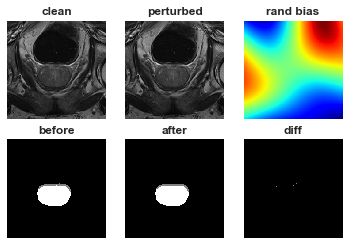

In [76]:
model.eval()
augmentor_bias.init_parameters()
rand_biased_image_tensor = augmentor_bias.forward(image_tensor)
with _disable_tracking_bn_stats(model):
    rand_pred_map = model(rand_biased_image_tensor.detach().clone()).max(1)[1].cpu().data.numpy()
perturbed_image =rand_biased_image_tensor.cpu().numpy()[0,0]
rand_bias= augmentor_bias.bias_field
print ('magnitude:', torch.max(torch.abs(rand_bias-1)))

## visualization
fig, axes = plt.subplots(2,3)
plot_image(cropped_image,ax= axes[0,0],title='clean')
plot_image(perturbed_image,ax= axes[0,1],title='perturbed')
plot_bias_field(rand_bias.cpu().numpy()[0,0],ax= axes[0,2],title='rand bias')
plot_image(pred_map[0],ax= axes[1,0],title='before')
plot_image(rand_pred_map[0],ax= axes[1,1],title='after')
plot_image(abs(rand_pred_map[0]-pred_map[0]),ax= axes[1,2],title='diff')



In [77]:
## apply adversarial training to find effective bias field
solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=[augmentor_affine,augmentor_noise,augmentor_bias,augmentor_morph],
        divergence_types = ['mse','contour'], ### you can also change it to 'mse' for mean squared error loss
        divergence_weights=[1.0,0.5],
        use_gpu= True,
        debug=True,
        if_norm_image=False
       )

## 4. start learning
solver.init_random_transformation()
rand_transformed_image = solver.forward(image_tensor.detach().clone())

with _disable_tracking_bn_stats(model):
        rand_predict = model.forward(rand_transformed_image)
warp_back_rand_predict= solver.predict_backward(rand_predict)

rand_bias = augmentor_bias.bias_field
rand_noise = augmentor_noise.param
rand_morph = augmentor_morph.get_deformation_displacement_field(-augmentor_morph.param)
print ('magnitude:', torch.max(torch.abs(rand_bias-1)))
model.zero_grad()
## 4.2 adv data augmentation 
loss = solver.adversarial_training(
        data=image_tensor,model=model,
        n_iter=1,
        lazy_load=[False]*4, ## if set to true, it will use the previous sampled random bias field as initialization.
        optimize_flags=[True,True,True,True],power_iteration=False)

adv_bias= augmentor_bias.bias_field
adv_noise = augmentor_noise.param
adv_morph = augmentor_morph.get_deformation_displacement_field(-augmentor_morph.param)
print ('magnitude:', torch.max(torch.abs(adv_bias-1)))

adv_transformed_image = solver.forward(image_tensor.detach().clone())
with _disable_tracking_bn_stats(model):
        adv_predict = model.forward(adv_transformed_image)

warp_back_adv_predict= solver.predict_backward(adv_predict)



min tensor([[0.]], device='cuda:0')
max tensor([[1.]], device='cuda:0')
magnitude: tensor(0.1412, device='cuda:0')
[True, True, True, True]
min tensor([[0.]], device='cuda:0')
max tensor([[1.]], device='cuda:0')
mse:0.006709669716656208
contour:0.026254720985889435
0 inner loop: dist 0.01983702927827835
update affine parameters
update noise parameters
update bias parameters
update morph parameters
min tensor([[0.]], device='cuda:0')
max tensor([[1.]], device='cuda:0')
mse:0.013401412405073643
contour:0.049344148486852646
outer loop loss tensor(0.0381, device='cuda:0', grad_fn=<DivBackward0>)
init out torch.Size([1, 3, 224, 224])
magnitude: tensor(0.2840, device='cuda:0')
min tensor([[0.]], device='cuda:0')
max tensor([[1.]], device='cuda:0')


In [79]:
sns.set(font_scale=10)

rand_transformed_image_numpy=rand_transformed_image.cpu().data.numpy()[0,0]
adv_transformed_image_numpy=adv_transformed_image.cpu().data.numpy()[0,0]

rand_predict_numpy=warp_back_rand_predict.max(1)[1].cpu().data.numpy()[0]
adv_predict_numpy=warp_back_adv_predict.max(1)[1].cpu().data.numpy()[0]

rand_before_warped_predict_numpy=rand_predict.max(1)[1].cpu().data.numpy()[0]
adv_before_warped_predict_numpy=adv_predict.max(1)[1].cpu().data.numpy()[0]



rand_bias_numpy=rand_bias.cpu().data.numpy()[0,0]
adv_bias_numpy=adv_bias.cpu().data.numpy()[0,0]


rand_noise_numpy=rand_noise.cpu().data.numpy()[0,0]
adv_noise_numpy=adv_noise.cpu().data.numpy()[0,0]

rand_morph_grid = rand_morph.permute(0,3,1,2)[0].data.cpu().numpy()
adv_morph_grid = adv_morph.permute(0,3,1,2)[0].data.cpu().numpy()

## deformed grid
gird_interval = 5
fig,axes = plt.subplots(2,9,figsize=(22,8))

plot_image(cropped_image,ax = axes[0,0],title="Input r'$\math{x}$'",font_size=font_size)
plot_noise(rand_noise_numpy,ax = axes[0,1],title='+Rand noise',font_size=font_size)

## plot perturbation
# plot_image(rand_transformed_image_numpy,ax = axes[0,1],title='perturbed',font_size=font_size)
# vis_noise(rand_noise_numpy, ax = axes[0,2],title = 'rand noise',font_size=font_size)
## plot deformation
plot_bias_field(rand_bias_numpy,ax= axes[0,2],title='+Rand bias')
plot_warped_grid(rand_morph_grid, ax=axes[0,3],bg_img=rand_transformed_image_numpy*0, interval=gird_interval, title="+Rand morph", fontsize=font_size, linewidth=0.5,show=True)
plot_image(rand_transformed_image_numpy, ax=axes[0,4],title="+Rand affine", font_size=font_size)

plot_image(pred_map[0],ax = axes[0,5],title='Before',font_size=font_size)
plot_image(rand_before_warped_predict_numpy,ax = axes[0,6],title='After',font_size=font_size)
plot_image(rand_predict_numpy,ax = axes[0,7],title='After (transformed back)',font_size=font_size)
plot_general(rand_predict_numpy-pred_map[0],ax = axes[0,8],title='Diff',font_size=font_size,cmap='seismic')


plot_image(cropped_image,title='Input',ax = axes[1,0],font_size=font_size)
plot_noise(adv_noise_numpy,ax = axes[1,1],title='+Adv noise',font_size=font_size)
plot_bias_field(adv_bias_numpy,ax= axes[1,2],title='+Adv bias')
# plot_image(adv_transformed_image_numpy,ax = axes[1,1],title='perturbed',font_size=font_size)
plot_warped_grid(adv_morph_grid, ax=axes[1,3],bg_img=adv_transformed_image_numpy*0, interval=gird_interval, title="+Adv morph", fontsize=font_size, linewidth=0.5,show=True)
# vis_noise(adv_noise_numpy, title = 'adv noise',ax = axes[1,2],font_size=font_size)
plot_image(adv_transformed_image_numpy, ax=axes[1,4],title="+Adv affine", font_size=font_size)
plot_image(pred_map[0],title='Before',ax = axes[1,5],font_size=font_size)
plot_image(adv_before_warped_predict_numpy,ax = axes[1,6],title='After',font_size=font_size)
plot_image(adv_predict_numpy,title='After^*',ax = axes[1,7],font_size=font_size)
plot_general(adv_predict_numpy-pred_map[0],ax = axes[1,8],title='Diff',font_size=font_size,cmap='seismic')
# plt.tight_layout(h_pad=0,w_pad=0.1)


plt.savefig('./test_chain_image.png')






ValueError: 
\math{x}
^
Unknown symbol: \math, found '\'  (at char 0), (line:1, col:1)

ValueError: 
\math{x}
^
Unknown symbol: \math, found '\'  (at char 0), (line:1, col:1)

<Figure size 1584x576 with 18 Axes>

In [78]:
## now you can simply learn effective adversarial bias fields on-the-fly to enhance training. a sample code will be like the following
## pseudo code for model optimization at one iteration: 
solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=[augmentor_bias],
        divergence_types = ['kl','contour'], ### you can also change it to 'mse' for mean squared error loss
        divergence_weights=[1.0,0.5],
        use_gpu= True,
        debug=False, ## turn off debugging information
       )

## unsupervised consistency loss
model.train()
init_output = model(image_tensor)
reg_loss = solver.adversarial_training(
        data=image_tensor,model=model, init_output=init_output.detach.clone(),
        n_iter=1,
        lazy_load=[False], 
        optimize_flags=[True],power_iteration=False)

## you can add it with the your original supervised loss (if have one). Below is a demo code for reference, do not run it.
model.train()
model.zero_grad()
supervised_loss = loss (init_output,label)
lamda=1
total_loss =supervised_loss+lamda*reg_loss
total_loss.backward()
optimizer.step() 



AttributeError: 'builtin_function_or_method' object has no attribute 'clone'